In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions, plot_xgb_feature_importance


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

################################# 数据 读取-处理 开始#################################
sheet = pd.read_excel('data_input_auto/中国柴油实际消费量.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['中国柴油实际消费量'].last_valid_index()

sheet = sheet.rename(columns={'全球经济惊喜指数': '全球经济惊喜指数（同花顺）'})

In [4]:

################################# 处理数据 让他们更适合 用来预测之后一个月的数据  #################################

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
# 所有数据截止到target_end
sheet = sheet[sheet.index <= target_end]


In [5]:
# 尝试多个可能的文件路径
file_paths = [
    os.path.expanduser("~/Desktop/X-BASE/天然气/eta/JKM_TTF_合并数据.xlsx"),                       
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/天然气/eta/JKM_TTF_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/天然气/eta/JKM_TTF_合并数据.xlsx")
]

file_path = None
for path in file_paths:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path = path
        break

if file_path is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.read_excel(file_path, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['真实值'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
    sheet1.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

In [6]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['JKM-TTF（$/MMBTU）'] = sheet_daily['JKM-TTF（$/MMBTU）'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [7]:
sheet.tail()

,中国柴油实际消费量,中国10年期国债收益率同差,水泥表观消费(预测/移动平均同比),周度螺纹表需(预测/移动平均同比),玻璃周度表需（考虑中游）(预测/移动平均同比),M1同比/3MMA,0#柴油价差（华东-山东）,JKM-TTF（$/MMBTU）,柴油情绪指数/4WMA,A股地产指数/沪深300 20日环比,A股基建指数/沪深300 20日环比,全球经济惊喜指数（同花顺）,WTI原油期货价格,铜油比,美国经济惊喜指数,南华工业品指数同比,南华黑色指数
Date,,,,,,,,,,,,,,,,,
2025-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-05,NaN,NaN,48.2217,211.1265,102.8619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:


################################# 处理缺失值 #################################
fill_methods = {
    '中国10年期国债收益率同差':'interpolate',            
    '水泥表观消费(预测/移动平均同比)':'interpolate', 
    '周度螺纹表需(预测/移动平均同比)':'interpolate',
    '玻璃周度表需（考虑中游）(预测/移动平均同比)':'interpolate', 
    'M1同比/3MMA':'interpolate', 
    '0#柴油价差（华东-山东）':'interpolate',
    'JKM-TTF（$/MMBTU）':'interpolate', 
    '柴油情绪指数/4WMA':'interpolate', 
    'A股地产指数/沪深300 20日环比':'interpolate',                                                                               
    'A股基建指数/沪深300 20日环比':'interpolate',
    '全球经济惊喜指数（同花顺）':'interpolate',                                                  
    'WTI原油期货价格':'interpolate', 
    '铜油比':'interpolate',
    '美国经济惊喜指数':'interpolate',
    '南华工业品指数同比':'interpolate',
    '南华黑色指数':'interpolate'                                                                                               
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '中国柴油实际消费量Non-Trend/F0.2'] = sheet.loc[:last_day, '中国柴油实际消费量Non-Trend/F0.2'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['中国10年期国债收益率同差_提前30天'] = sheet['中国10年期国债收益率同差'].shift(30)
sheet['M1同比/3MMA_提前100天'] = sheet['M1同比/3MMA'].shift(100)
sheet['0#柴油价差（华东-山东）_提前20天'] = sheet['0#柴油价差（华东-山东）'].shift(20)
sheet['柴油情绪指数/4WMA_提前100天'] = sheet['柴油情绪指数/4WMA'].shift(100)
sheet['A股地产指数/沪深300 20日环比_提前20天'] = sheet['A股地产指数/沪深300 20日环比'].shift(20)
sheet['A股基建指数/沪深300 20日环比_提前20天'] = sheet['A股基建指数/沪深300 20日环比'].shift(20)
sheet['全球经济惊喜指数（同花顺）_提前120天'] = sheet['全球经济惊喜指数（同花顺）'].shift(120)        
sheet['WTI原油期货价格_提前60天'] = sheet['WTI原油期货价格'].shift(60)    
sheet['铜油比_提前60天'] = sheet['铜油比'].shift(60) 
sheet['美国经济惊喜指数_提前150天'] = sheet['美国经济惊喜指数'].shift(150)  
sheet['南华工业品指数同比_提前90天'] = sheet['南华工业品指数同比'].shift(90)
sheet['南华黑色指数_提前80天'] = sheet['南华黑色指数'].shift(80)
sheet['JKM-TTF（$/MMBTU）']

sheet['铜油比_提前60天_逆序'] = reverse_column(sheet, '铜油比_提前60天')
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2022-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['中国柴油实际消费量'].notna())
]

################################# 数据 读取-处理 结束 #################################

In [9]:
sheet_daily.columns

Index(['Date', '中国柴油实际消费量', '中国10年期国债收益率同差', '水泥表观消费(预测/移动平均同比)',
       '周度螺纹表需(预测/移动平均同比)', '玻璃周度表需（考虑中游）(预测/移动平均同比)', 'M1同比/3MMA',
       '0#柴油价差（华东-山东）', 'JKM-TTF（$/MMBTU）', '柴油情绪指数/4WMA',
       'A股地产指数/沪深300 20日环比', 'A股基建指数/沪深300 20日环比', '全球经济惊喜指数（同花顺）',
       'WTI原油期货价格', '铜油比', '美国经济惊喜指数', '南华工业品指数同比', '南华黑色指数',
       '中国10年期国债收益率同差_提前30天', 'M1同比/3MMA_提前100天', '0#柴油价差（华东-山东）_提前20天',
       '柴油情绪指数/4WMA_提前100天', 'A股地产指数/沪深300 20日环比_提前20天',
       'A股基建指数/沪深300 20日环比_提前20天', '全球经济惊喜指数（同花顺）_提前120天', 'WTI原油期货价格_提前60天',
       '铜油比_提前60天', '美国经济惊喜指数_提前150天', '南华工业品指数同比_提前90天', '南华黑色指数_提前80天',
       '铜油比_提前60天_逆序'],
      dtype='object')

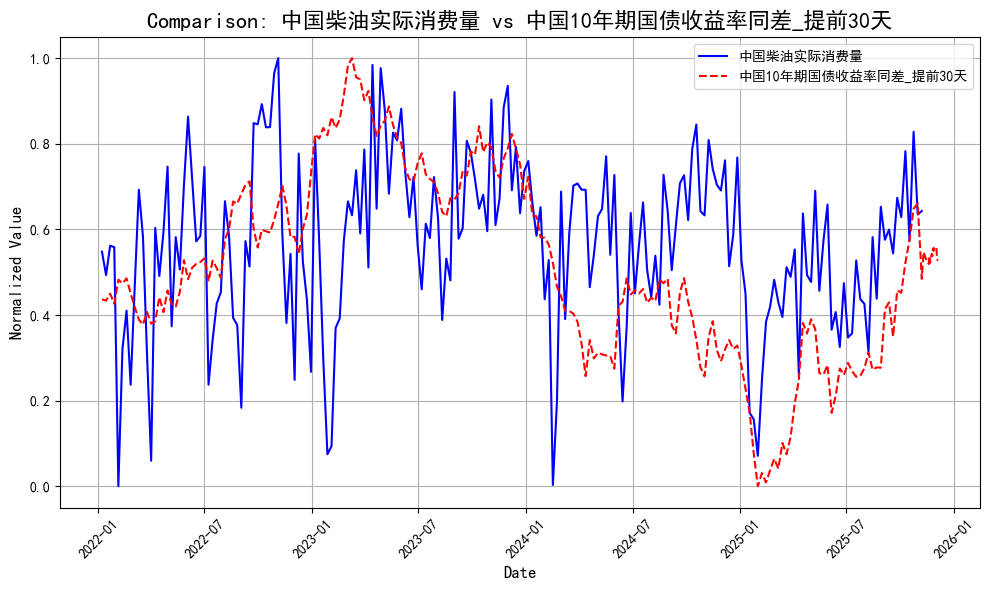

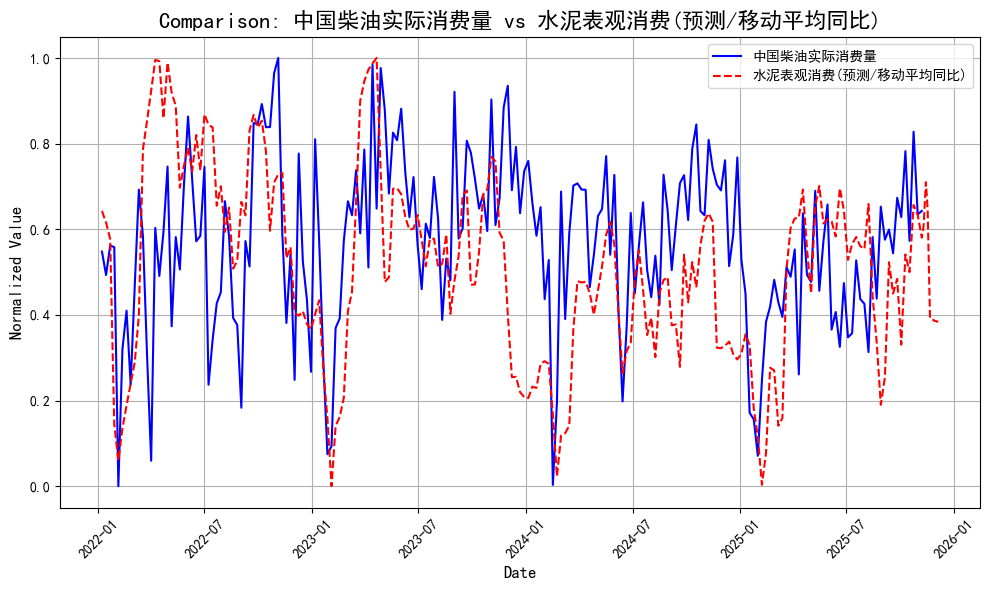

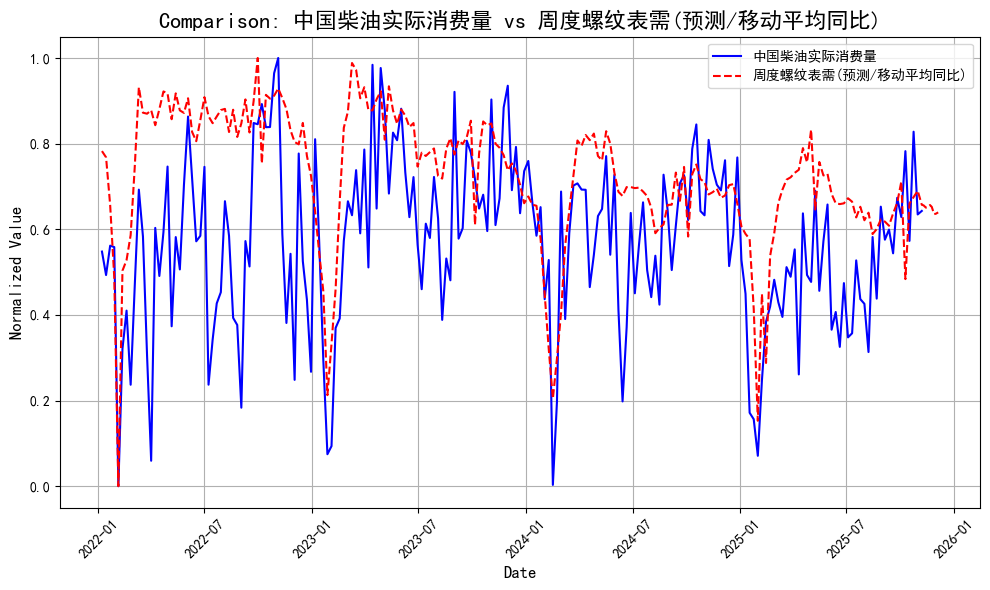

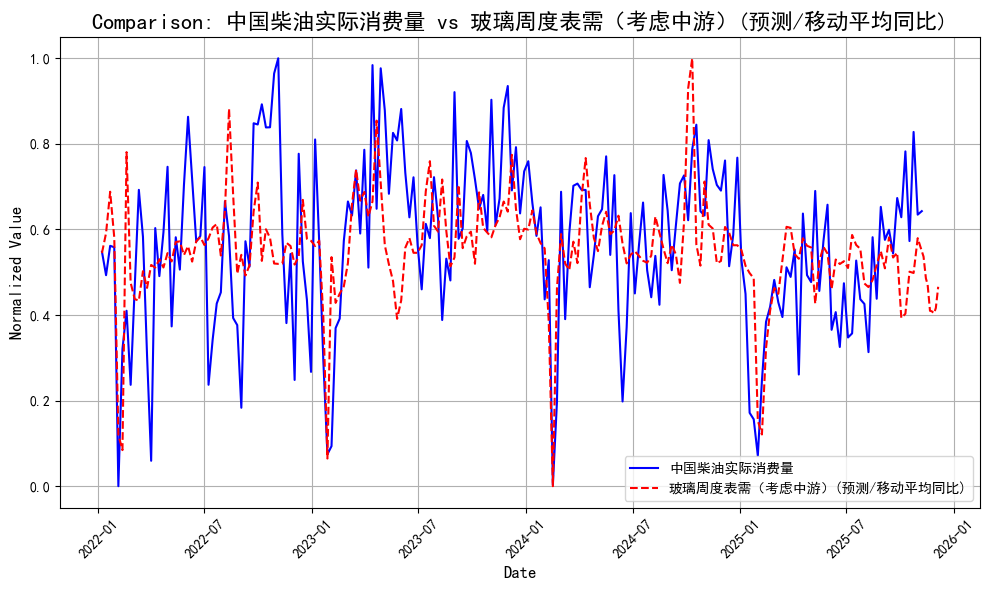

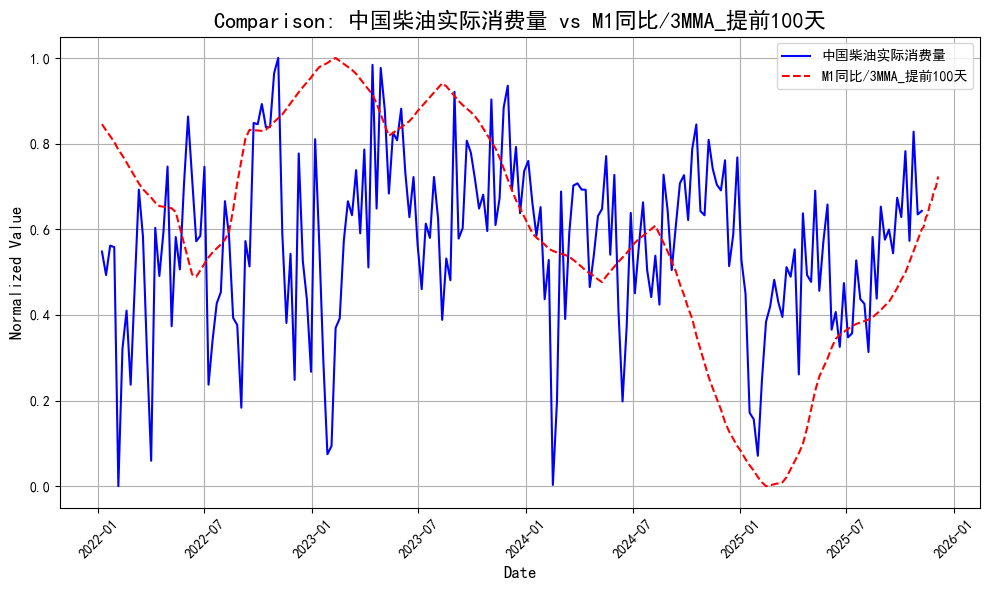

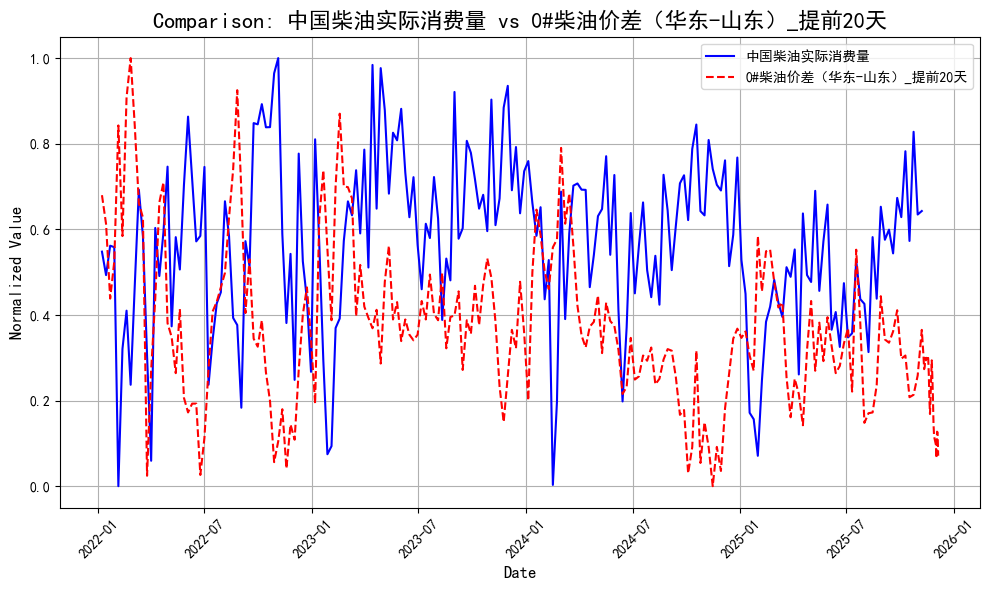

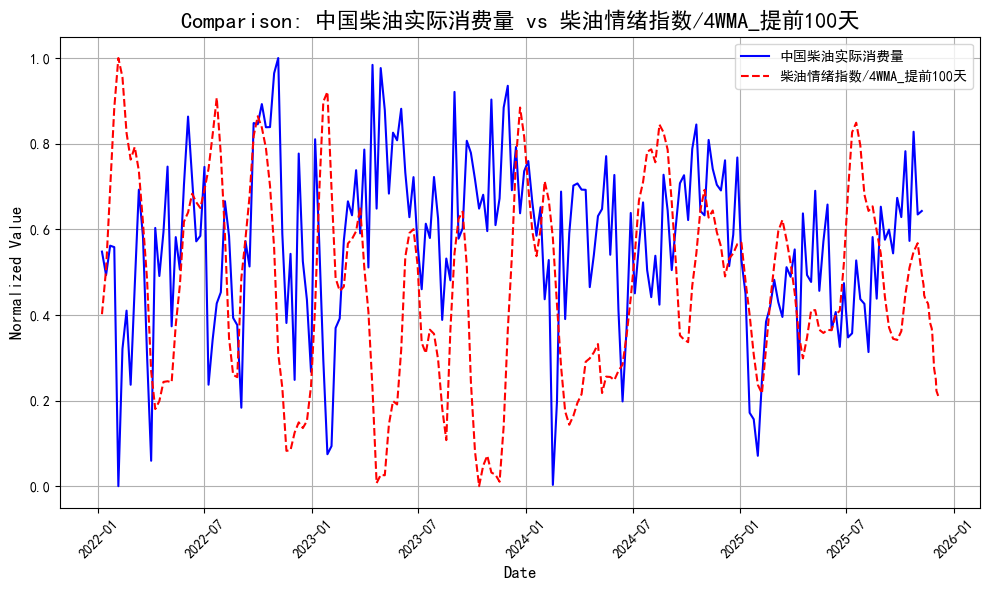

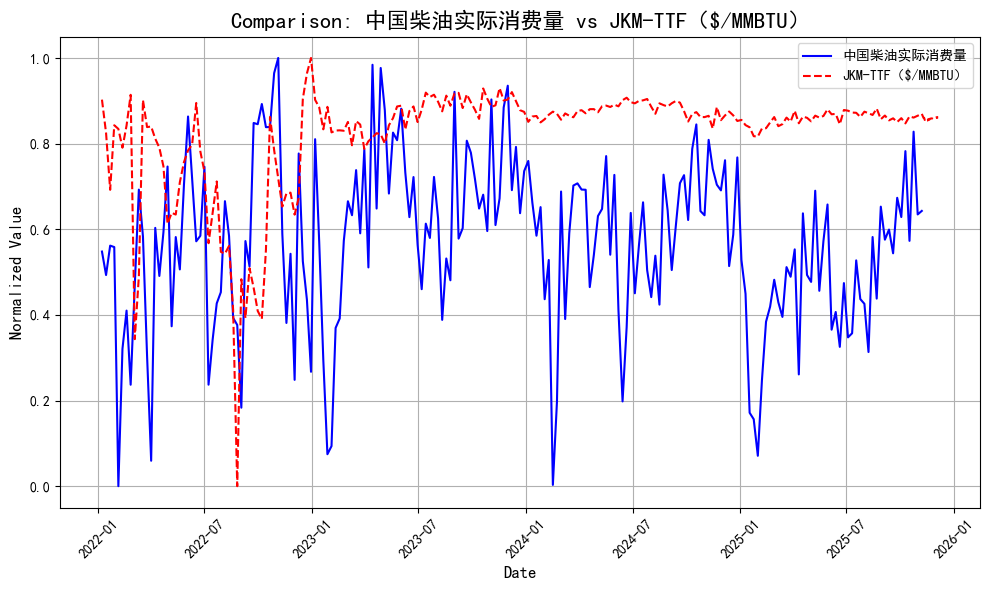

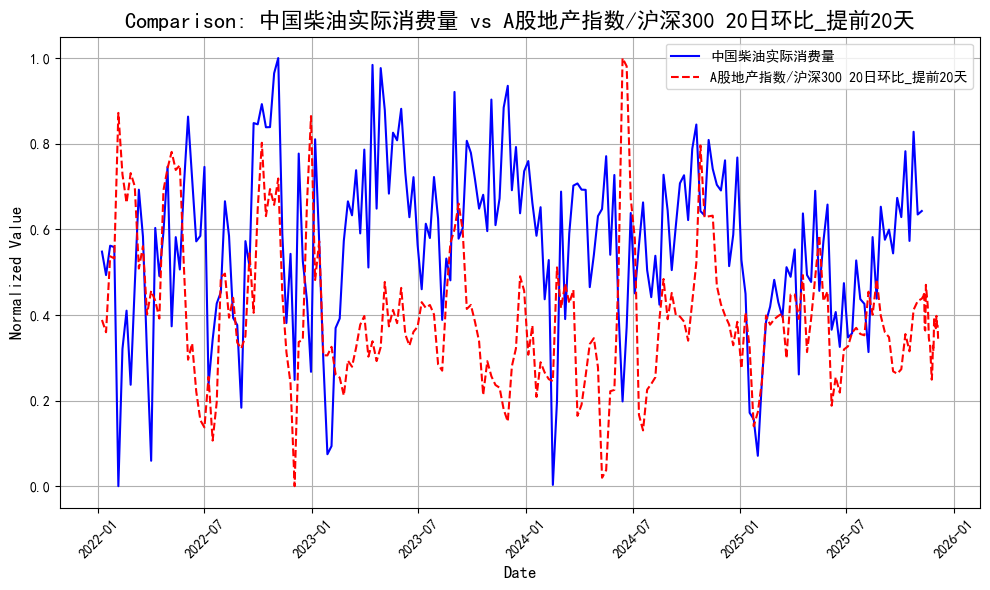

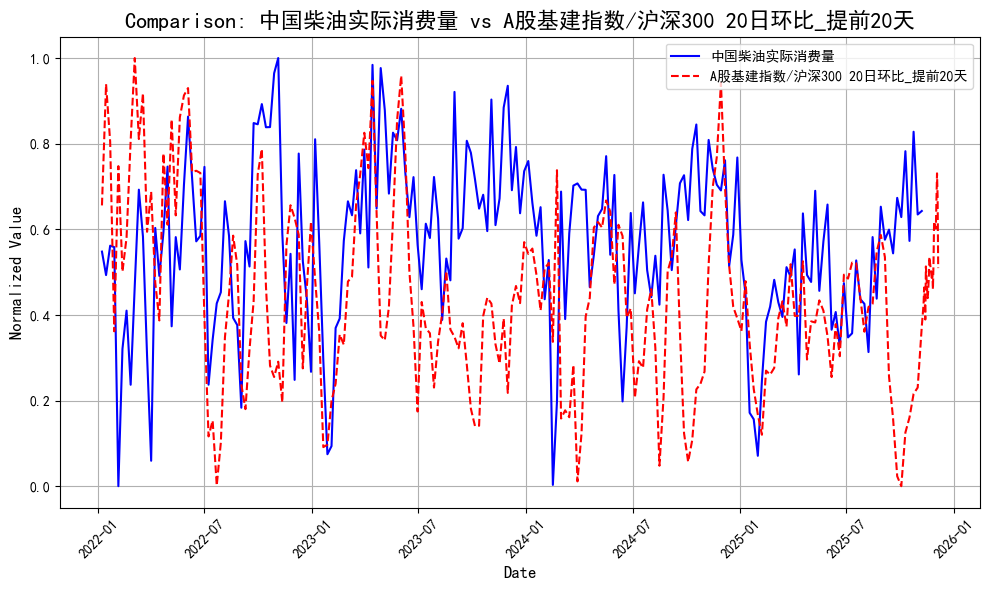

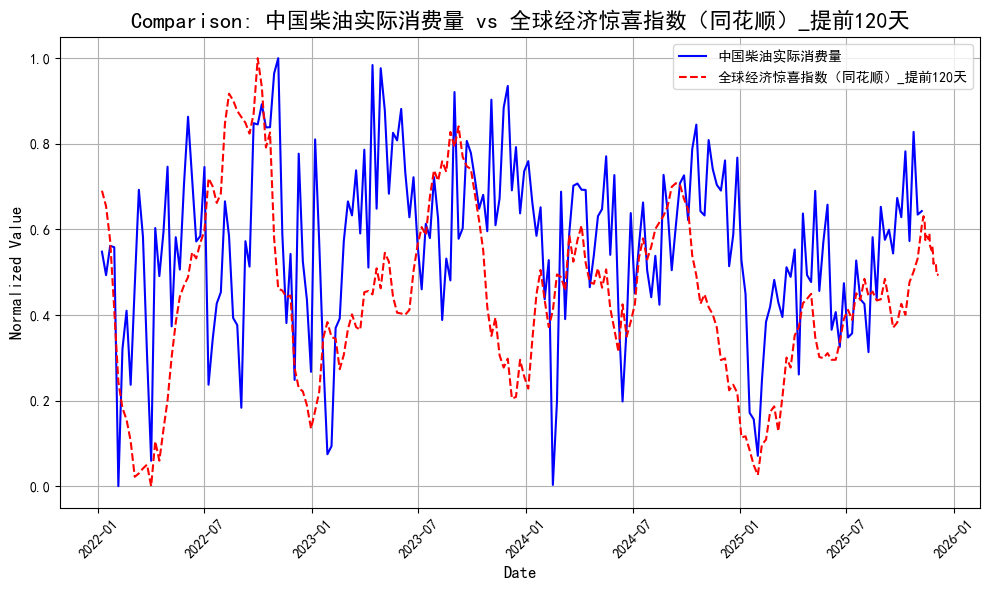

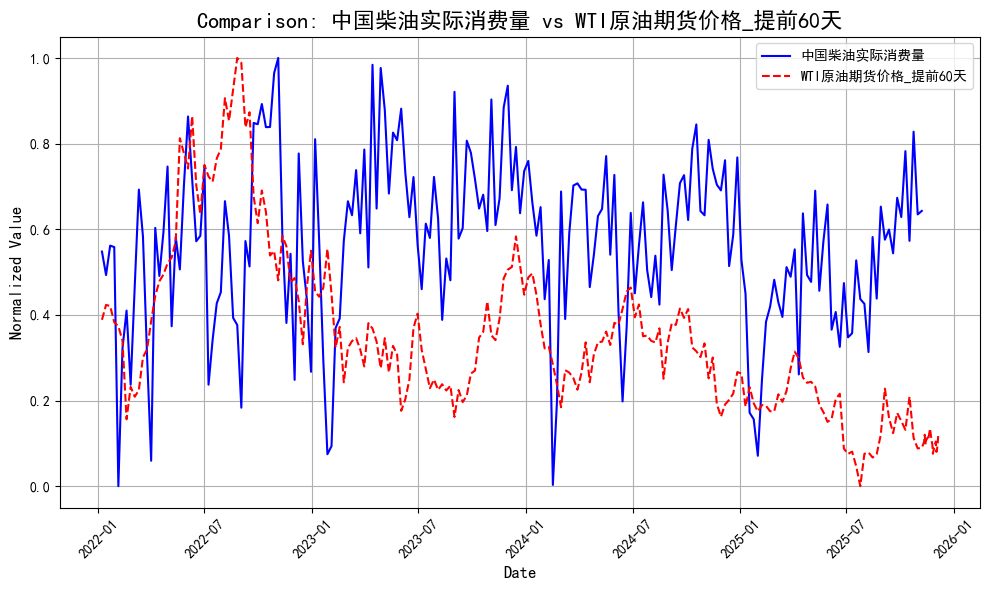

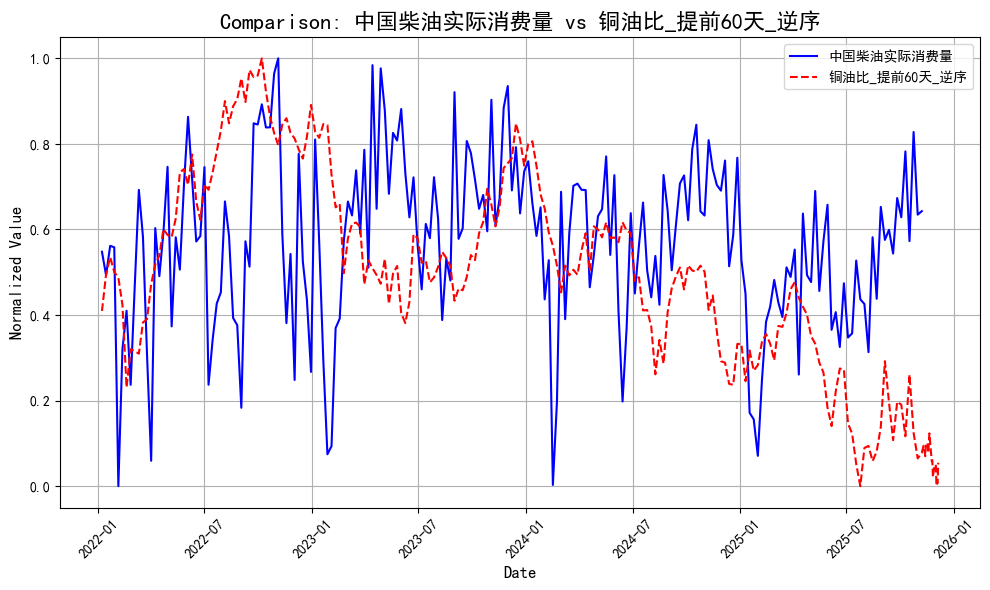

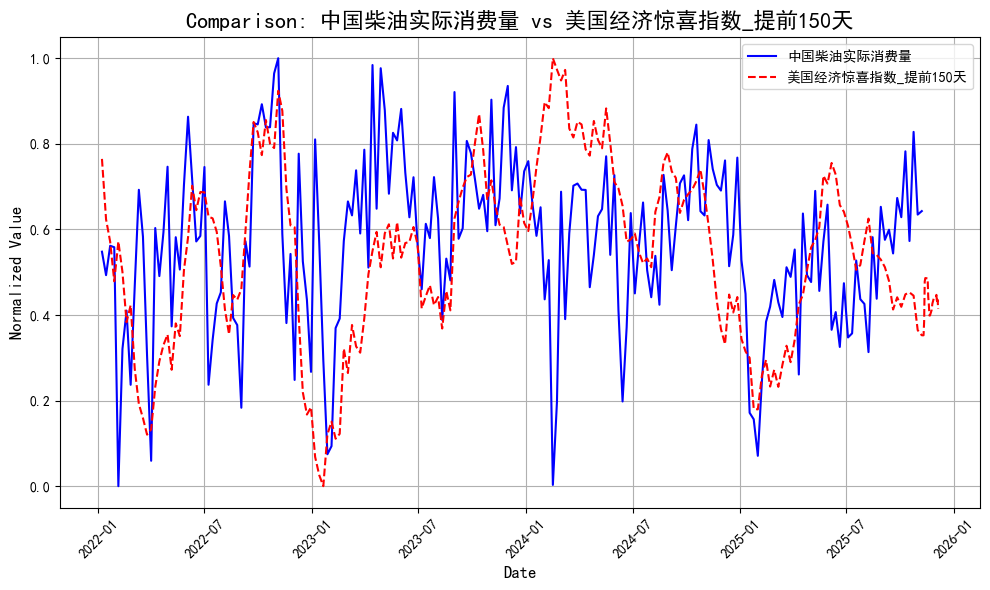

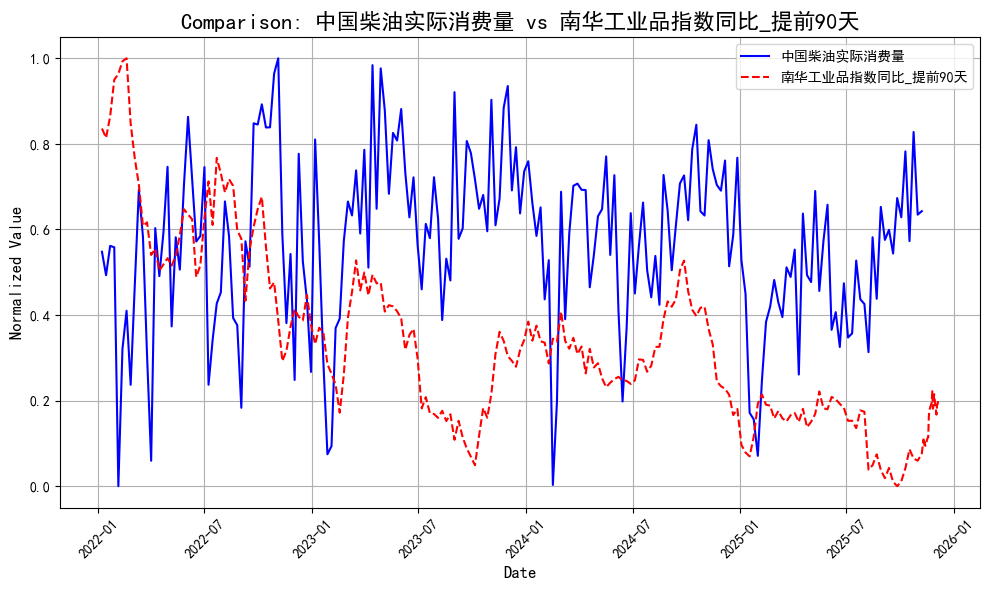

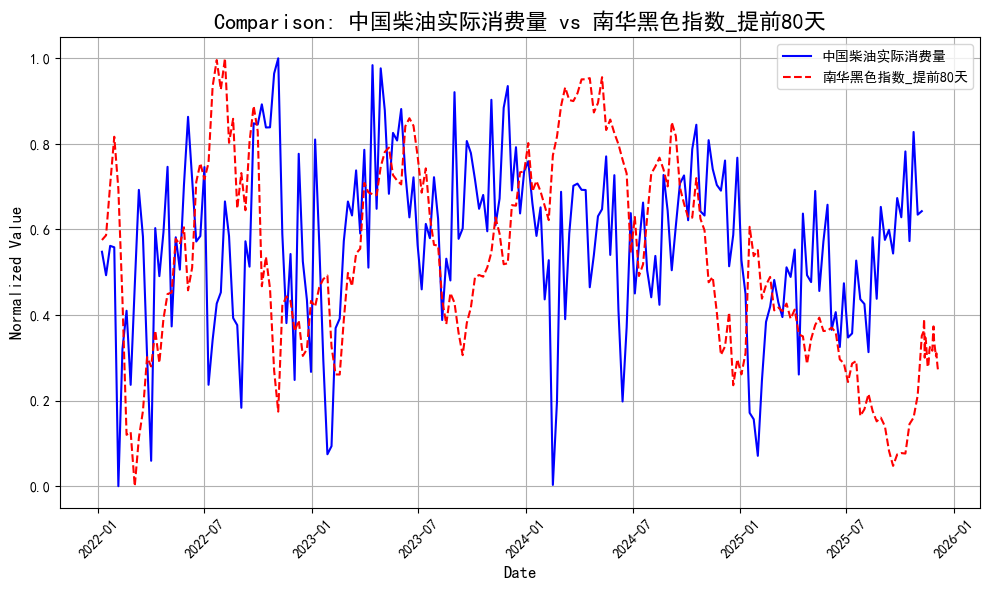

In [10]:
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='中国柴油实际消费量', 
    compare_cols=[
        '中国10年期国债收益率同差_提前30天',
        '水泥表观消费(预测/移动平均同比)',
        '周度螺纹表需(预测/移动平均同比)',
        '玻璃周度表需（考虑中游）(预测/移动平均同比)',
        'M1同比/3MMA_提前100天',
        '0#柴油价差（华东-山东）_提前20天',
        '柴油情绪指数/4WMA_提前100天',
        'JKM-TTF（$/MMBTU）',
        'A股地产指数/沪深300 20日环比_提前20天',
        'A股基建指数/沪深300 20日环比_提前20天',
        '全球经济惊喜指数（同花顺）_提前120天',
        'WTI原油期货价格_提前60天',
        '铜油比_提前60天_逆序',
        '美国经济惊喜指数_提前150天',
        '南华工业品指数同比_提前90天',
        '南华黑色指数_提前80天'
       ]
)

In [11]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 10
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '中国10年期国债收益率同差_提前30天',
        '水泥表观消费(预测/移动平均同比)',
        '周度螺纹表需(预测/移动平均同比)',
        '玻璃周度表需（考虑中游）(预测/移动平均同比)',
        'M1同比/3MMA_提前100天',
        '0#柴油价差（华东-山东）_提前20天',
        '柴油情绪指数/4WMA_提前100天',
        'JKM-TTF（$/MMBTU）',
        'A股地产指数/沪深300 20日环比_提前20天',
        'A股基建指数/沪深300 20日环比_提前20天',
        '全球经济惊喜指数（同花顺）_提前120天',
        'WTI原油期货价格_提前60天',
        '铜油比_提前60天_逆序',
        '美国经济惊喜指数_提前150天',
        '南华工业品指数同比_提前90天',
        '南华黑色指数_提前80天'
        
]

predict_column = '中国柴油实际消费量'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01,  # 较小的学习率
    'max_depth': 12,  # 控制树的深度防止过拟合
    'min_child_weight': 0.3,  # 控制过拟合
    'subsample': 0.8,  # 随机采样防止过拟合
    'colsample_bytree': 0.8,  # 特征随机采样
    'gamma': 2,  # 控制分裂
    'reg_alpha': 0.9,  # L1正则化
    'reg_lambda': 0.8,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
    'tree_method': 'auto'
}

num_boost_round = 3000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=100 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:24.07285	train-rmse:39.03170


[100]	eval-rmse:30.20290	train-rmse:20.33955


[200]	eval-rmse:33.57336	train-rmse:11.24069


[300]	eval-rmse:34.70667	train-rmse:6.58451


[400]	eval-rmse:35.41747	train-rmse:4.13841


[500]	eval-rmse:35.74463	train-rmse:2.71537


[600]	eval-rmse:35.84659	train-rmse:1.86985


[700]	eval-rmse:35.84309	train-rmse:1.36973


[800]	eval-rmse:35.85603	train-rmse:1.09685


[900]	eval-rmse:35.85790	train-rmse:0.96092


[1000]	eval-rmse:35.88032	train-rmse:0.88959


[1100]	eval-rmse:35.87846	train-rmse:0.86227


[1200]	eval-rmse:35.86737	train-rmse:0.84522


[1300]	eval-rmse:35.87657	train-rmse:0.83549


[1400]	eval-rmse:35.86384	train-rmse:0.82829


[1500]	eval-rmse:35.86199	train-rmse:0.82241


[1600]	eval-rmse:35.85793	train-rmse:0.81687


[1700]	eval-rmse:35.85272	train-rmse:0.81169


[1800]	eval-rmse:35.84924	train-rmse:0.80879


[1900]	eval-rmse:35.84715	train-rmse:0.80569


[2000]	eval-rmse:35.83827	train-rmse:0.80109


[2100]	eval-rmse:35.84243	train-rmse:0.79871


[2200]	eval-rmse:35.84205	train-rmse:0.79332


[2300]	eval-rmse:35.84500	train-rmse:0.79165


[2400]	eval-rmse:35.84756	train-rmse:0.79070


[2500]	eval-rmse:35.85185	train-rmse:0.78899


[2600]	eval-rmse:35.85106	train-rmse:0.78797


[2700]	eval-rmse:35.84207	train-rmse:0.78552


[2800]	eval-rmse:35.84421	train-rmse:0.78524


[2900]	eval-rmse:35.84325	train-rmse:0.78350


[2999]	eval-rmse:35.84985	train-rmse:0.78161


训练集 MSE (DMatrix): 0.6826, 训练集 R² (DMatrix): 0.9996
测试集 MSE (DMatrix): 1285.212, 测试集 R² (DMatrix): -2.9752


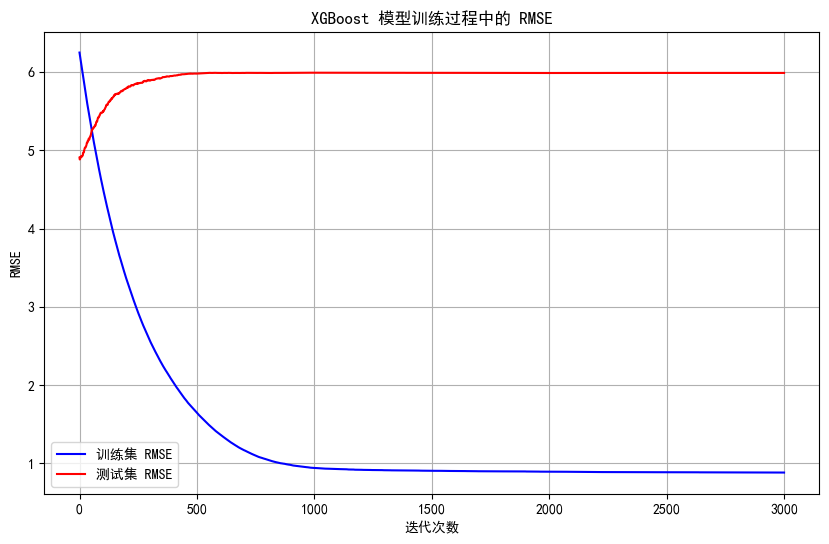

In [12]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=200
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:38.36851


[200]	train-rmse:11.08094


[400]	train-rmse:4.07540


[600]	train-rmse:1.84322


[800]	train-rmse:1.09113


[1000]	train-rmse:0.88803


[1200]	train-rmse:0.84435


[1400]	train-rmse:0.82786


[1600]	train-rmse:0.81555


[1800]	train-rmse:0.80434


[2000]	train-rmse:0.79743


[2200]	train-rmse:0.79136


[2400]	train-rmse:0.78635


[2600]	train-rmse:0.78494


[2800]	train-rmse:0.77965


[2999]	train-rmse:0.77653


全部数据 MSE: 0.6728, 全部数据 R²: 0.9996


Gap between last actual value and first prediction: 1.792349121093764


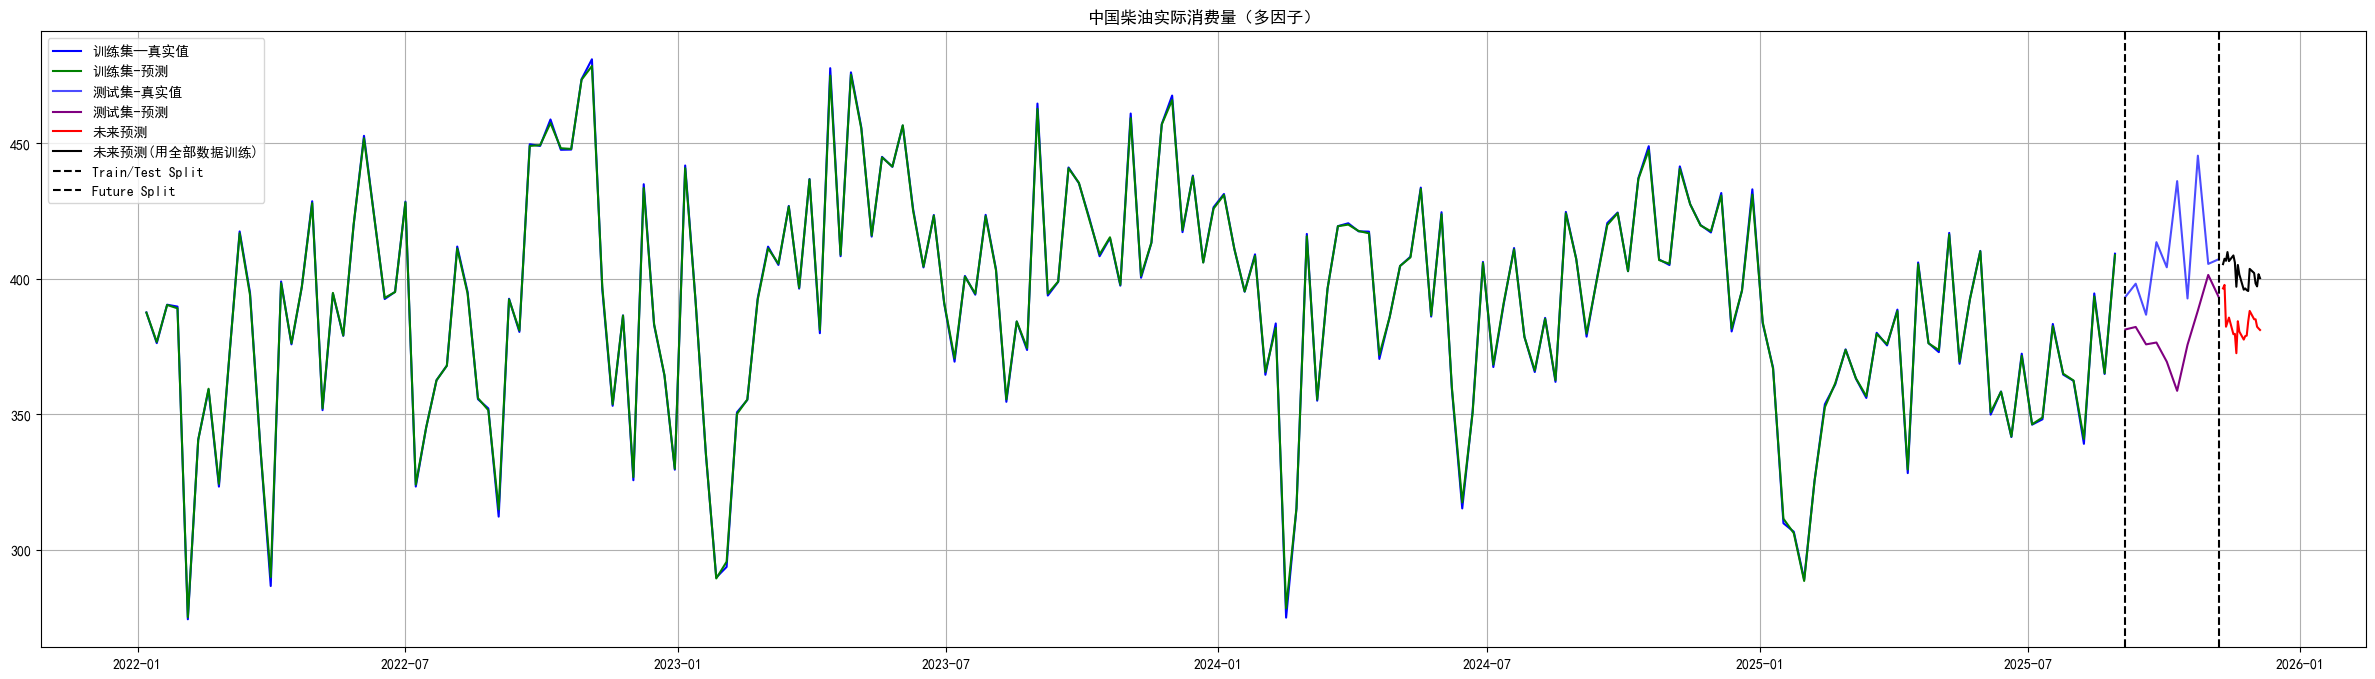

In [14]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('中国柴油实际消费量（多因子）')
plt.legend()
plt.grid(True)
plt.show()


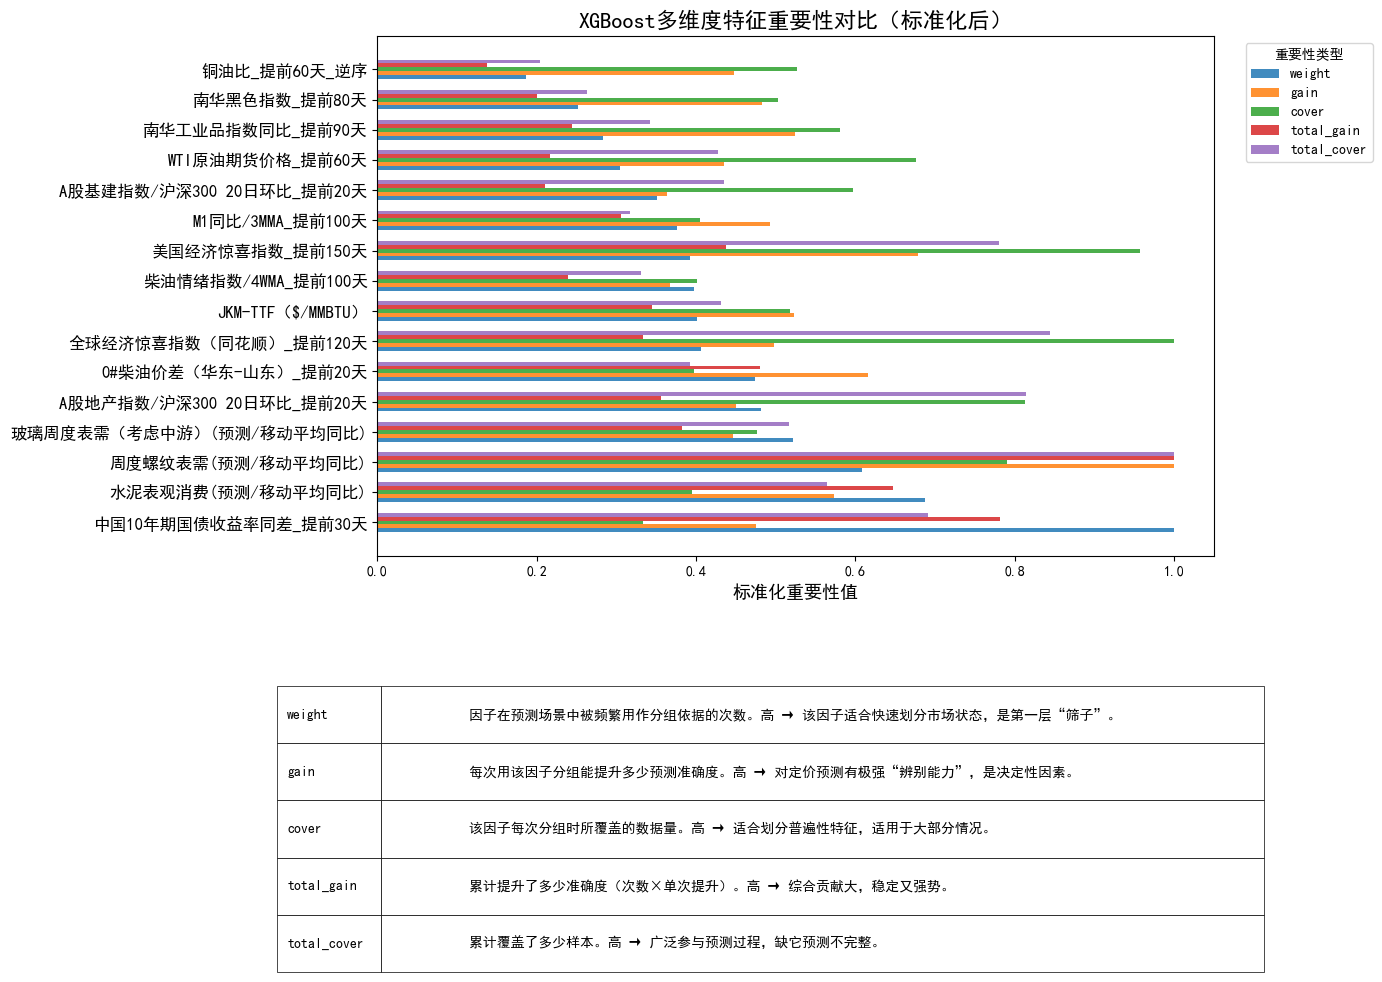

,weight,gain,cover,total_gain,total_cover
中国10年期国债收益率同差_提前30天,1.000000,0.475732,0.332935,0.782098,0.691933
水泥表观消费(预测/移动平均同比),0.687626,0.572745,0.394990,0.647459,0.564473
周度螺纹表需(预测/移动平均同比),0.608276,1.000000,0.791032,1.000000,1.000000
玻璃周度表需（考虑中游）(预测/移动平均同比),0.521294,0.446400,0.476567,0.382565,0.516310
A股地产指数/沪深300 20日环比_提前20天,0.481519,0.450063,0.813571,0.356275,0.814166
0#柴油价差（华东-山东）_提前20天,0.474689,0.616115,0.398184,0.480805,0.392823
全球经济惊喜指数（同花顺）_提前120天,0.406589,0.498487,1.000000,0.333203,0.845007
JKM-TTF（$/MMBTU）,0.401165,0.523460,0.517864,0.345228,0.431761
柴油情绪指数/4WMA_提前100天,0.397951,0.366848,0.400970,0.240002,0.331625
美国经济惊喜指数_提前150天,0.392125,0.678384,0.956992,0.437320,0.779898


In [15]:
plot_xgb_feature_importance(model_all, X_train)

---

In [16]:
################################# 训练预测数据 excel格式输出  #################################

############ 日度 数据 ############
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})

historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})

merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/中国柴油实际消费量(多因子)_合并数据.xlsx', index=False,float_format='%.4f')

############ 月度 数据 ############
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
test_pred_2024 = test_data[['Date', '预测值']].copy()
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 将数值列保留一位小数
merged_df_monthly['真实值'] = merged_df_monthly['真实值'].round(1)
merged_df_monthly['预测值'] = merged_df_monthly['预测值'].round(1)

merged_df_monthly.to_excel('eta/中国柴油实际消费量(多因子)_月度数据.xlsx', index=False,float_format= '%.4f')

In [17]:
merged_df_daily.head()

,Date,真实值,预测值
168,2025/12/05,NaN,400.147858
167,2025/12/04,NaN,401.627686
166,2025/12/03,NaN,397.123260
165,2025/12/02,NaN,398.190308
164,2025/12/01,NaN,402.049377


In [18]:
merged_df_monthly.head()

,Date,真实值,预测值
35,2025/12/31,NaN,399.799988
34,2025/11/30,407.1,402.100006
33,2025/10/31,416.7,378.600006
32,2025/09/30,397.9,378.899994
31,2025/08/31,374.0,374.100006


---

In [19]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中国柴油实际消费量(多因子)"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [20]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中国柴油实际消费量(多因子)"
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
